In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random as random
from functools import partial

from mm_sbi_review.examples.misspec_ma1 import assumed_dgp, calculate_summary_statistics, true_dgp

In [2]:
def MA1(t1, n_obs=100, batch_size=1, random_state=None):
    r"""Generate a sequence of samples from the MA2 model.

    The sequence is a moving average

        x_i = w_i + \theta_1 w_{i-1}

    where w_i are white noise ~ N(0,1).

    Parameters
    ----------
    t1 : float, array_like
    n_obs : int, optional
    batch_size : int, optional
    random_state : RandomState, optional

    """
    # Make inputs 2d arrays for broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))

    random_state = random_state or np.random

    # i.i.d. sequence ~ N(0,1)
    w = random_state.randn(batch_size, n_obs + 2)
    x = w[:, 2:] + t1 * w[:, 1:-1]
    return x.reshape((batch_size, -1))  # ensure 2D


def stochastic_volatility(w=-0.736,
                          rho=0.9,
                          sigma_v=0.36,
                          n_obs=100,
                          batch_size=1,
                          random_state=None):
    """Sample for a stochastic volatility model.

    specified in Frazier and Drovandi (2021). This is the true Data
    Generating Process for this example.
    Uses a normally distributed shock term.

    Parameters
    ----------
    w : float, optional
    rho : float, optional
    sigma_v : float, optional
    n_obs : int, optional
    batch_size : int, optional
    random_state : RandomState, optional

    Returns
    -------
    y_mat : np.array

    """
    random_state = random_state or np.random

    h_mat = np.zeros((batch_size, n_obs))
    y_mat = np.zeros((batch_size, n_obs))

    w_vec = np.repeat(w, batch_size)
    rho_vec = np.repeat(rho, batch_size)
    sigma_v_vec = np.repeat(sigma_v, batch_size)

    h_mat[:, 0] = w_vec + random_state.normal(0, 1, batch_size) * sigma_v_vec
    y_mat[:, 0] = np.exp(h_mat[:, 0]/2) * random_state.normal(0, 1, batch_size)

    for i in range(n_obs - 1):
        h_mat[:, i] = w_vec + rho_vec * h_mat[:, i-1] + \
            random_state.normal(0, 1, batch_size) * sigma_v_vec
        y_mat[:, i] = np.exp(h_mat[:, i]/2)*random_state.normal(0, 1, batch_size)

    return y_mat.reshape((batch_size, -1))  # ensure 2d


def autocov(x, lag=0):
    """Return the autocovariance.

    Assumes a (weak) univariate stationary process with mean 0.
    Realizations are in rows.

    Parameters
    ----------
    x : np.array of size (n, m)
    lag : int, optional

    Returns
    -------
    C : np.array of size (n,)

    """
    x = np.atleast_2d(x)
    # In R this is normalized with x.shape[1]
    if lag == 0:
        C = np.mean(x[:, :] ** 2, axis=1)
    else:
        C = np.mean(x[:, lag:] * x[:, :-lag], axis=1)

    return C


In [3]:
import elfi
from elfi.methods.bsl import pre_sample_methods, pdf_methods

n_obs = 100
seed_obs = 123
true_params = [-0.736, 0.9, 0.36]
y = stochastic_volatility(*true_params, n_obs=n_obs,
                            random_state=np.random.RandomState(seed_obs))

sim_fn = partial(MA1, n_obs=n_obs)

m = elfi.ElfiModel()
elfi.Prior('uniform', -1, 2, model=m, name='t1')
elfi.Simulator(sim_fn, m['t1'], observed=y, name='MA1')
elfi.Summary(autocov, m['MA1'], name='S1')
elfi.Summary(autocov, m['MA1'], 1, name='S2')

Summary(name='S2')

In [4]:
ssy = [autocov(y), autocov(y, 1)]

In [5]:
feature_names = ['S1', 'S2']
params = {'t1': .99}
nsim = [100, 300, 500, 5000, 10_000, 20_000]
likelihood = pdf_methods.standard_likelihood()
seed = 1
std_value = pre_sample_methods.log_SL_stdev(m, params, nsim, feature_names, likelihood=likelihood, M=100, seed=seed)
std_value


array([2.70513229, 1.38699066, 1.13124341, 0.34957616, 0.27459253,
       0.1974124 ])

In [6]:
nsim_round = 500
standard_bsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [7]:
mcmc_iterations = 22_200   # sample size
est_post_cov = np.array([[0.5]])  # covariance matrix for the proposal distribution
params0 = [0.99]
res = standard_bsl.sample(mcmc_iterations, est_post_cov, params0=params0, burn_in=0)
print(res)


Progress [==================================================] 100.0% Complete
Method: BSL
Number of samples: 22200
Number of simulations: 6913500
MCMC Acceptance Rate: 0.155
Parameter                Mean               2.5%              97.5%
t1:                     0.123             -0.976              0.984




(array([ 956.,  832., 1149., 1046.,  733.,  755.,  683.,  672.,  435.,
         460.,  377.,  321.,  184.,  123.,  102.,   45.,   42.,   65.,
          59.,   43.,   49.,   41.,   46.,   51.,   45.,   43.,   50.,
          25.,   76.,   41.,   63.,   76.,   49.,   71.,  123.,  129.,
         248.,  181.,  280.,  566.,  601.,  668., 1038.,  985., 1515.,
        1230., 1196., 1212., 1005., 1415.]),
 array([-9.99377021e-01, -9.59389645e-01, -9.19402270e-01, -8.79414894e-01,
        -8.39427518e-01, -7.99440143e-01, -7.59452767e-01, -7.19465392e-01,
        -6.79478016e-01, -6.39490641e-01, -5.99503265e-01, -5.59515889e-01,
        -5.19528514e-01, -4.79541138e-01, -4.39553763e-01, -3.99566387e-01,
        -3.59579012e-01, -3.19591636e-01, -2.79604260e-01, -2.39616885e-01,
        -1.99629509e-01, -1.59642134e-01, -1.19654758e-01, -7.96673826e-02,
        -3.96800070e-02,  3.07368570e-04,  4.02947441e-02,  8.02821197e-02,
         1.20269495e-01,  1.60256871e-01,  2.00244246e-01,  2.402316

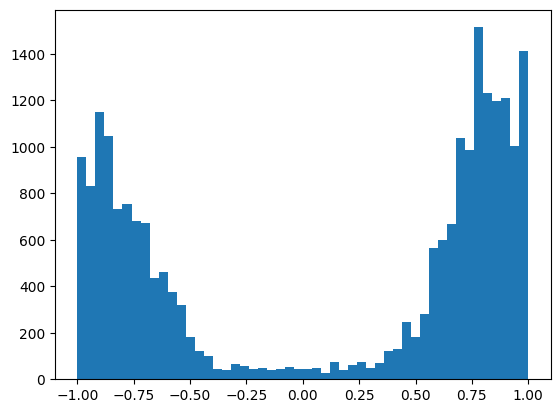

In [8]:
posterior_samples = res.samples['t1']
plt.hist(posterior_samples, bins=50)

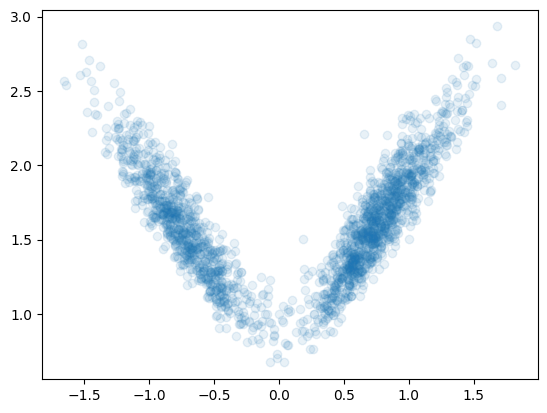

In [9]:
# posterior predictive simulations
posterior_pred_sims = np.empty((2_000, 2))

for i in range(2_000):
    t1 = posterior_samples[5*i]  # thin - only every 5th sample
    y = sim_fn(t1)
    posterior_pred_sims[i, 0] = autocov(y)
    posterior_pred_sims[i, 1] = autocov(y, 1)
    
plt.plot(posterior_pred_sims[:, 1], posterior_pred_sims[:, 0], 'o', alpha=0.1)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Update font size for consistency
plt.rcParams.update({'font.size': 24})

# Assume that `res.samples['t1']` contains the posterior samples
# and `sim_fn` is the simulation function using the assumed DGP
# Also, `autocov` is the function to calculate autocovariance

# Extract posterior samples
posterior_samples = res.samples['t1']

def b_theta(t):
    return np.array([1 + t ** 2, t])

# Generate values for b_theta
t_vals = np.linspace(-1, 1, 101)
b_theta_vals = np.array([b_theta(t) for t in t_vals])
# Plot the histogram of posterior samples
plt.figure(figsize=(8, 6))
plt.hist(posterior_samples, bins=50, density=True, alpha=0.6, color='blue', label='Posterior Samples')

# Plot the prior distribution for comparison
theta_range = np.linspace(-1, 1, 200)

# Plot the pseudo-true parameter value
theta_pseudo_true = 0.0  # Adjust based on your context
plt.axvline(theta_pseudo_true, color='black', linestyle='--', label='Pseudo-true θ')

# Add labels and legend
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
# plt.title('Posterior Distribution of $\theta$')
plt.legend()
plt.tight_layout()
plt.xlim([-1, 1])
plt.xticks([-1, 0, 1])
plt.yticks([0, 0.5, 1.0, 1.5])
plt.savefig("figs/fig2a.pdf")
plt.clf()

# Posterior predictive simulations
num_posterior_samples = len(posterior_samples)
num_pp_samples = 2_000  # Number of posterior predictive samples

# Initialize array to store summary statistics
posterior_pred_sims = np.empty((num_pp_samples, 2))

# Perform posterior predictive simulations
for i in range(num_pp_samples):
    t1 = posterior_samples[i]
    y = sim_fn(t1)
    posterior_pred_sims[i, 0] = autocov(y, lag=0)
    posterior_pred_sims[i, 1] = autocov(y, lag=1)

# Plot the joint distribution of summary statistics from posterior predictive simulations
plt.figure(figsize=(8, 6))
plt.scatter(posterior_pred_sims[:, 1], posterior_pred_sims[:, 0], c='blue', alpha=0.1,)

# Plot the observed summary statistics
plt.scatter(ssy[1], ssy[0], c='black', marker='x', s=100, label='S(y)')

# Plot the b_theta function for reference
plt.plot(b_theta_vals[:, 1], b_theta_vals[:, 0], color='orange', label=r'$b(\theta)$', linewidth=6)

# Set axis limits and labels
plt.xlim(-2.0, 2.0)
plt.ylim(-0.5, 2.5)
plt.xticks([-2, 0, 2])
plt.yticks([-0.5, 1, 2.5])
plt.xlabel(r'$\zeta_1$')
plt.ylabel(r'$\zeta_2$')
# plt.title('Posterior Predictive Summary Statistics')
plt.legend()
plt.tight_layout()
plt.savefig("figs/fig2b.pdf")
plt.clf()


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>